# **Modeling Non-Stationarity And Finding An Equilibrium**
By

> Emmanuel Oppong


## **Introduction**
In financial markets, the behavior of asset prices often shows non-stationarity, posing challenges for econometric modeling and prediction. As such, identifying equilibrium relationships among non-stationary time series becomes important for understanding long-term co-movements and short-term deviations. Thus, this project focuses on Modeling Non-Stationarity and Finding an Equilibrium through the application of cointegration techniques and Error Correction Models (ECM). Using real-world financial datasets, we demonstrate how cointegrated stock prices reveal both long-term equilibrium and short-term fluctuations, providing valuable insights for trading strategies and risk management. The analysis involves a systematic approach: testing for stationarity, validating cointegration with econometric tests, calibrating model parameters, and evaluating residual diagnostics to ensure model adequacy. By applying the ECM framework, particularly to the relationship between Visa and Mastercard, the project highlights how deviations from equilibrium can be corrected over time, offering a rigorous econometric foundation for forecasting and investment decision-making. __[Click here](https://docs.google.com/document/d/1vSTUJ6exiXhRtGk6flTo_sJ8MgXg24VxO34dRVCVa6A/edit?usp=sharing)__ to acess the report.

# Initialization

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 5.8 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from arch.unitroot import ADF
from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import UECM

# Z-Score Function

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

# Engel-Granger (EG) Test

In [ ]:
# Engel-Granger (EG) Test Function
# ticker1 = Yahoo Ticker symbol
# ticker2 = Yahoo Ticker symbol
# time_period = The time period you would like to track (Ex: 1mo/5y) default 5y
# time_end = The ending time period. default is now.

def eg_test(ticker1,ticker2,time_period="5y",time_end=None):

  ticker1_data = yf.Ticker(ticker1)
  ticker2_data = yf.Ticker(ticker2)

  ticker1_hist = ticker1_data.history(period=time_period,end=time_end)
  ticker2_hist = ticker2_data.history(period=time_period,end=time_end)

  # Tickers Line Plot
  print()
  t1_name=ticker1_data.info["shortName"]
  t2_name=ticker2_data.info["shortName"]
  plt.figure(figsize=(12,7))
  sns.lineplot(ticker1_hist["Close"], label=t1_name)
  sns.lineplot(ticker2_hist["Close"], label=t2_name).set(title=f'Historical price of {t1_name} and {t2_name}')
  #plt.ylabel('Closed Price')
  #plt.title(f'Historical price of {yf.Ticker(ticker1).info["shortName"]} and {yf.Ticker(ticker2).info["shortName"]}')
  #plt.xticks(rotation=45)
  #plt.legend()
  plt.show()

  # ADF test
  print()
  print(f'* ADF TEST FOR {ticker1} AND {ticker2}')
  # ADF Test Results for ticker1
  ticker1_adf = ADF(ticker1_hist["Close"], trend="n", method="bic")
  print()
  print(f"{ticker1} Augmented Dickey-Fuller Unit Root Test\n", ticker1_adf.regression.summary)
  print("\nTest statistics and critical values: \n", ticker1_adf)

  # ADF Test Results for ticker2
  ticker2_adf = ADF(ticker2_hist["Close"], trend="n", method="bic")
  print()
  print(f"{ticker2} Augmented Dickey-Fuller Unit Root Test\n", ticker2_adf.regression.summary)
  print("\nTest statistics and critical values: \n", ticker2_adf)

  # First difference test
  print()
  print(f'* FIRST DIFFERENCE TEST FOR {ticker1} AND {ticker2}')

  # ADF Test Results for First Difference ticker 1
  ticker1_d_adf = ADF(ticker1_hist["Close"].diff().dropna(), trend="n", method="bic")
  print()
  print(f"First Difference of {ticker1} Augmented Dickey-Fuller Unit Root Test\n",
        ticker1_d_adf.regression.summary(),)
  print("\nTest statistics and critical values: \n", ticker1_d_adf)


  # ADF Test Results for First Difference of ticker 2
  ticker2_d_adf = ADF(ticker2_hist["Close"].diff().dropna(), trend="n", method="bic")
  print()
  print(f"First Difference of {ticker2} Augmented Dickey-Fuller Unit Root Test\n",
  ticker2_d_adf.regression.summary(),
  )
  print("\nTest statistics and critical values: \n", ticker2_d_adf)

  t1_sta = ({False:"NO",True:"YES"}[ticker1_adf.stat<ticker1_adf.critical_values["5%"]])
  t1d_sta = ({False:"NO",True:"YES"}[ticker1_d_adf.stat<ticker1_d_adf.critical_values["5%"]])
  t2_sta = ({False:"NO",True:"YES"}[ticker2_adf.stat<ticker2_adf.critical_values["5%"]])
  t2d_sta = ({False:"NO",True:"YES"}[ticker2_d_adf.stat<ticker2_d_adf.critical_values["5%"]])
  adf_summary = pd.DataFrame(
    {
        f"{t1_name} Stock Price": (ticker1_adf.stat, ticker1_adf.critical_values["5%"], t1_sta),
        f"| {t1_name} Return": (ticker1_d_adf.stat, ticker1_d_adf.critical_values["5%"], t1d_sta),
        f"| {t2_name} Stock Price": (ticker2_adf.stat, ticker2_adf.critical_values["5%"], t2_sta),
        f"| {t2_name} Return": (ticker2_d_adf.stat, ticker2_d_adf.critical_values["5%"], t2d_sta),
    },
    index=["ADF Test Statistic", "5% Critical Value", "Stationarity"],
  )

  print("\nADF TEST SUMMARY\n")
  display(adf_summary)
  print("\nIf the Stock Price is non stationary and the return is Stationary,")
  print("then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.")
  print("If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.\n")


  # PO cointegration test
  print()
  print("* COINTEGRATION TEST")
  # Two-Step Residual Based Test for Cointegration for 2 tickers
  # (aka Phillips and Ouliaris cointegration test)
  print()
  print(phillips_ouliaris(
      ticker1_hist["Close"], ticker2_hist["Close"], trend="c", test_type="Za", kernel="bartlett"
        )
      )
  print("\nIf the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.\n")



# Error Correction Model

In [ ]:
def ec_model(ticker1,ticker2,time_period="5y",time_end=None):

  ticker1_data = yf.Ticker(ticker1)
  ticker2_data = yf.Ticker(ticker2)

  ticker1_hist = ticker1_data.history(period=time_period,end=time_end)
  ticker2_hist = ticker2_data.history(period=time_period,end=time_end)

  ticker1_price = ticker1_hist["Close"].rename(ticker1, inplace = True)
  ticker2_price = ticker2_hist["Close"].rename(ticker2, inplace = True)

  t1_name=ticker1_data.info["shortName"]
  t2_name=ticker2_data.info["shortName"]

  ecm = UECM(
    endog=pd.DataFrame(ticker1_price),
    lags=1,
    exog=pd.DataFrame(ticker2_price),
    order=1,
    trend="ct",
    ).fit()
  print("\n")
  print(ecm.summary())
  print("\n")

  predicted_val = ecm.fittedvalues.cumsum()+ticker1_price[0]
  #ecm.fittedvalues.head()

  plt.figure(figsize=(8,3))
  sns.lineplot(ecm.fittedvalues, label="residuals").set(title=f'Residual plot of {t1_name} vs Predicted Values of ECM')
  plt.show()

  dw_summary = pd.DataFrame(
    {
        "Durbin-Watson Test for ECM residuals":
          (f"{t1_name} and {t2_name}",
           durbin_watson(ecm.fittedvalues),
           "No auto-correlation if around 2"),
    },
    index=["Data Pairs", "Result", "Interpretation"],
  )

  # Durbin-Watson Test Result for ECM
  display(dw_summary)

  # Tickers Line Plot
  print()
  plt.figure(figsize=(8,5))
  sns.lineplot(ticker1_price, label=t1_name)
  #sns.lineplot(ticker2_price, label=t2_name)
  sns.lineplot(predicted_val, label="Predicted Values").set(title=f'Historical price of {t1_name} vs Predicted Values of ECM')
  plt.show()

  """
  z_score=zscore((ticker1_price-predicted_val))
  z_score.plot(figsize=(9,3),title="Z-Score")
  plt.axhline(z_score.mean())
  plt.axhline(1.0, color='red')
  plt.axhline(-1.0, color='green')
  #plt.xlim('2013-01-01', '2018-01-01')
  plt.show()

  # Tickers Buy and Sell Signal
  print()
  plt.figure(figsize=(8,5))
  buy = ticker1_price.copy()
  sell = ticker1_price.copy()
  buy[z_score>-1] = 0
  sell[z_score<1] = 0
  #sns.lineplot(ticker1_price, label=t1_name)
  #sns.lineplot(predicted_val, label="Predicted Values").set(title=f'Buying and Selling signal for {t1_name} based on Z-Score')
  ticker1_price.plot(title=f'Buying and Selling signal for {t1_name} based on Z-Score')
  predicted_val.plot()
  buy.plot(color='g', linestyle='None', marker='^')
  sell.plot(color='r', linestyle='None', marker='^')
  x1, x2, y1, y2 = plt.axis()
  plt.axis((x1, x2, ticker1_price.min()-20, ticker1_price.max()+20))
  plt.legend([t1_name, "Predicted Values", 'Buy Signal', 'Sell Signal'])
  plt.show()
  """
  return predicted_val;

#Dataset of Amazon, Netflix, and Domino Pizza

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/stocks.csv'
data = pd.read_csv("/content/drive/MyDrive/stocks.csv")

In [ ]:
# Convert date variable to date format and set index
data["Date2"] = pd.to_datetime(data["Date"], format="%m/%d/%Y")
data_set = data.loc[:,].set_index("Date2")

# Selecting columns and setting index
data = data.loc[:, ["Date2", "AMZN","NFLX","DPZ"]].set_index("Date2")

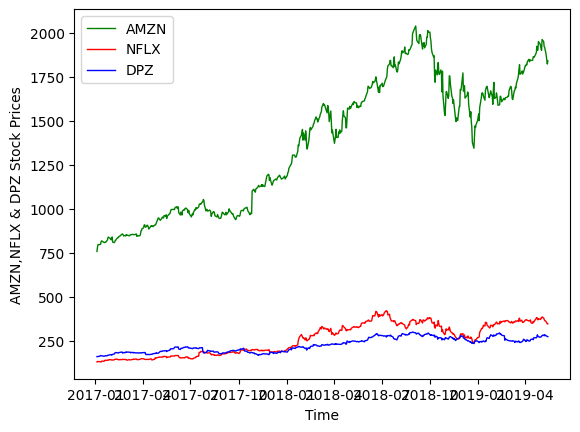

In [ ]:
# Amzn and Nflx Plot from 2017 to 2019
plt.plot(data.AMZN, linewidth=1, c="g", label="AMZN")
plt.plot(data.NFLX, linewidth=1, c="r", label="NFLX")
plt.plot(data.DPZ, linewidth=1, c="b", label="DPZ")
plt.xlabel("Time")
plt.ylabel("AMZN,NFLX & DPZ Stock Prices")
plt.legend()
plt.show()

In [ ]:
# ADF Test Results for NFLX
Amzn_adf = ADF(data.AMZN, trend="n", method="bic")
print(
    "AMZN Augmented Dickey-Fuller Unit Root Test\n", Amzn_adf.regression.summary()
)
print("\nTest statistics and critical values: \n", Amzn_adf)

# ADF Test Results for DPZ
print("\n", "# " * 39, "\n")
Dpz_adf = ADF(data.DPZ, trend="n", method="bic")
print(
    "Dpz Augmented Dickey-Fuller Unit Root Test\n", Dpz_adf.regression.summary()
)
print("\nTest statistics and critical values: \n", Dpz_adf)

# ADF Test Results for NFLX
print("\n", "# " * 39, "\n")
Nflx_adf = ADF(data.NFLX, trend="n", method="bic")
print(
    "Dpz Augmented Dickey-Fuller Unit Root Test\n", Nflx_adf.regression.summary()
)
print("\nTest statistics and critical values: \n", Nflx_adf)

AMZN Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.496
Date:                Sun, 07 Apr 2024   Prob (F-statistic):                       0.222
Time:                        11:15:27   Log-Likelihood:                         -2808.0
No. Observations:                 592   AIC:                                      5618.
Df Residuals:                     591   BIC:                                      5622.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

In [ ]:
# ADF Test Results for First Difference of AMZN Stock Prices
Amzn_d_adf = ADF(data.AMZN.diff().dropna(), trend="n", method="bic")
print(
    "First Difference of AMZN Augmented Dickey-Fuller Unit Root Test\n",
    Amzn_d_adf.regression.summary(),
)
print("\nTest statistics and critical values: \n", Amzn_d_adf)

# ADF Test Results for First Difference of DPZ Stock Prices
print("\n", "# " * 39, "\n")
Dpz_d_adf = ADF(data.DPZ.diff().dropna(), trend="n", method="bic")
print(
    "First Difference of DPZ Augmented Dickey-Fuller Unit Root Test\n",
    Dpz_d_adf.regression.summary(),
)
print("\nTest statistics and critical values: \n", Dpz_d_adf)

# ADF Test Results for First Difference of NFLX Stock Prices
Nflx_d_adf = ADF(data.NFLX.diff().dropna(), trend="n", method="bic")
print(
    "First Difference of NFLX Augmented Dickey-Fuller Unit Root Test\n",
    Nflx_d_adf.regression.summary(),
)
print("\nTest statistics and critical values: \n", Nflx_d_adf)

First Difference of AMZN Augmented Dickey-Fuller Unit Root Test
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.515
Model:                            OLS   Adj. R-squared (uncentered):              0.514
Method:                 Least Squares   F-statistic:                              625.5
Date:                Sun, 07 Apr 2024   Prob (F-statistic):                    1.14e-94
Time:                        11:15:27   Log-Likelihood:                         -2803.9
No. Observations:                 591   AIC:                                      5610.
Df Residuals:                     590   BIC:                                      5614.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t| 

In [ ]:
# Two-Step Residual Based Test for Cointegration for DPZ and AMZN
# (aka Phillips and Ouliaris cointegration test)
print(
    phillips_ouliaris(
        data.DPZ, data.AMZN, trend="c", test_type="Za", kernel="bartlett"
    )
)

Phillips-Ouliaris Za Cointegration Test
Statistic: -23.98954142048311
P-value: 0.024259837379800777
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 4.8280
Trend: c
Distribution Order: 3


In [ ]:
# Two-Step Residual Based Test for Cointegration for DPZ and NFLX
# (aka Phillips and Ouliaris cointegration test)
print(
    phillips_ouliaris(
        data.DPZ, data.NFLX, trend="c", test_type="Za", kernel="bartlett"
    )
)

Phillips-Ouliaris Za Cointegration Test
Statistic: -21.429120176451256
P-value: 0.041897286627081295
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 3.7895
Trend: c
Distribution Order: 3


In [ ]:
# Two-Step Residual Based Test for Cointegration for NFLX and AMZN
# (aka Phillips and Ouliaris cointegration test)
print(
    phillips_ouliaris(
        data.NFLX, data.AMZN, trend="c", test_type="Za", kernel="bartlett"
    )
)

Phillips-Ouliaris Za Cointegration Test
Statistic: -15.846152626729884
P-value: 0.12706079902565137
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 1.8966
Trend: c
Distribution Order: 3


In [ ]:
# Error Correction Model Result for AMZN on DPZ
ecm_model = UECM(
    endog=pd.DataFrame(data.DPZ),
    lags=0,
    exog=pd.DataFrame(data.AMZN),
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

# Durbin-Watson Test Result for ECM of DPZ and AMZN
print(durbin_watson(ecm_model.fittedvalues))

                              UECM Model Results                              
Dep. Variable:                  D.DPZ   No. Observations:                  593
Model:                     UECM(0, 1)   Log Likelihood               -1629.750
Method:               Conditional MLE   S.D. of innovations            229.353
Date:                Sun, 07 Apr 2024   AIC                           3269.500
Time:                        11:15:27   BIC                           3291.426
Sample:                             1   HQIC                          3278.040
                                  593                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4378      1.133      3.034      0.003       1.213       5.663
DPZ.L1        -0.0365      0.011     -3.422      0.001      -0.057      -0.016
AMZN.L1        0.0036      0.001      3.170      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Error Correction Model Result for AMZN on DPZ
ecm_model = UECM(
    endog=pd.DataFrame(data.DPZ),
    lags=0,
    exog=pd.DataFrame(data.NFLX),
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

# Durbin-Watson Test Result for ECM of DPZ and NFLX
print(durbin_watson(ecm_model.fittedvalues))

                              UECM Model Results                              
Dep. Variable:                  D.DPZ   No. Observations:                  593
Model:                     UECM(0, 1)   Log Likelihood               -1636.472
Method:               Conditional MLE   S.D. of innovations            229.354
Date:                Sun, 07 Apr 2024   AIC                           3282.944
Time:                        11:15:27   BIC                           3304.870
Sample:                             1   HQIC                          3291.484
                                  593                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7874      1.239      3.056      0.002       1.353       6.222
DPZ.L1        -0.0310      0.010     -3.251      0.001      -0.050      -0.012
NFLX.L1        0.0129      0.004      2.996      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Error Correction Model Result for AMZN on DPZ
ecm_model = UECM(
    endog=pd.DataFrame(data.NFLX),
    lags=0,
    exog=pd.DataFrame(data.AMZN),
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

# Durbin-Watson Test Result for ECM of AMZN and DPZ
print(durbin_watson(ecm_model.fittedvalues))

                              UECM Model Results                              
Dep. Variable:                 D.NFLX   No. Observations:                  593
Model:                     UECM(0, 1)   Log Likelihood               -1820.961
Method:               Conditional MLE   S.D. of innovations            274.150
Date:                Sun, 07 Apr 2024   AIC                           3651.922
Time:                        11:15:27   BIC                           3673.848
Sample:                             1   HQIC                          3660.462
                                  593                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3600      0.934     -0.385      0.700      -2.195       1.475
NFLX.L1       -0.0192      0.009     -2.122      0.034      -0.037      -0.001
AMZN.L1        0.0039      0.002      1.853      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#Dataset of Coca Cola, Pepsi, and Mc Donald

## Coca Cola vs Pepsi

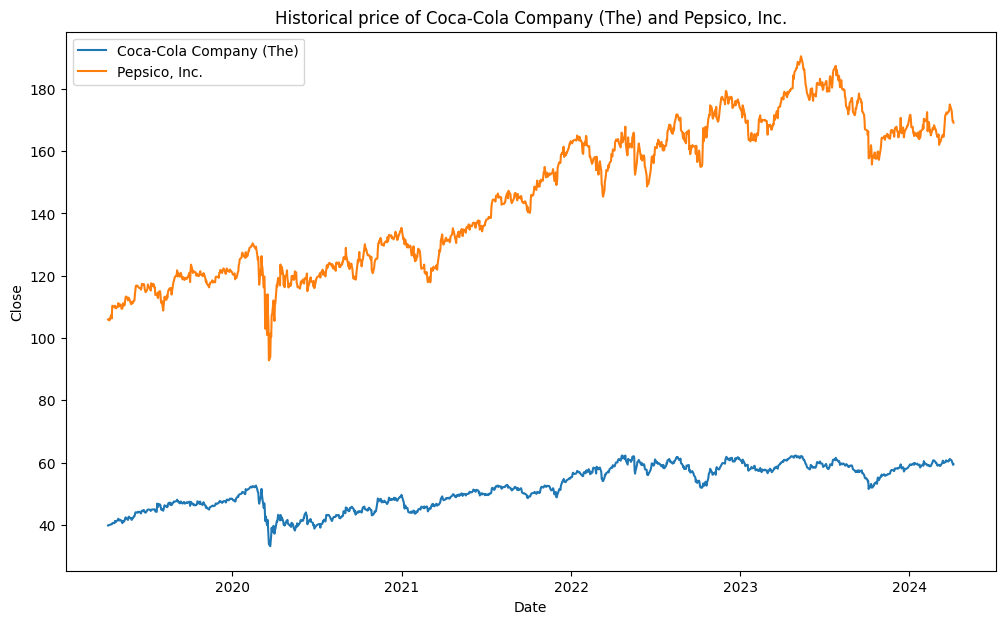


* ADF TEST FOR KO AND PEP

KO Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f7203a0>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.611
P-value                         0.849
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

PEP Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda80061d80>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.920
P-value                         0.904
Lags                                1
-------------------------------------

Trend: N

,Coca-Cola Company (The) Stock Price,| Coca-Cola Company (The) Return,"| Pepsico, Inc. Stock Price","| Pepsico, Inc. Return"
ADF Test Statistic,0.61101,-36.733275,0.919977,-42.454489
5% Critical Value,-1.941216,-1.941216,-1.941216,-1.941216
Stationarity,NO,YES,NO,YES



If the Stock Price is non stationary and the return is Stationary,
then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.
If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.


* COINTEGRATION TEST

Phillips-Ouliaris Za Cointegration Test
Statistic: -20.23874885608861
P-value: 0.05368223503355752
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 15.120
Trend: c
Distribution Order: 3

If the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.



In [ ]:
eg_test("KO","PEP")

Since the P-value of Coca Cola vs Pepsi Stocks are greater than 0.05, they are not cointegrated.

## Coca Cola vs Mc Donald

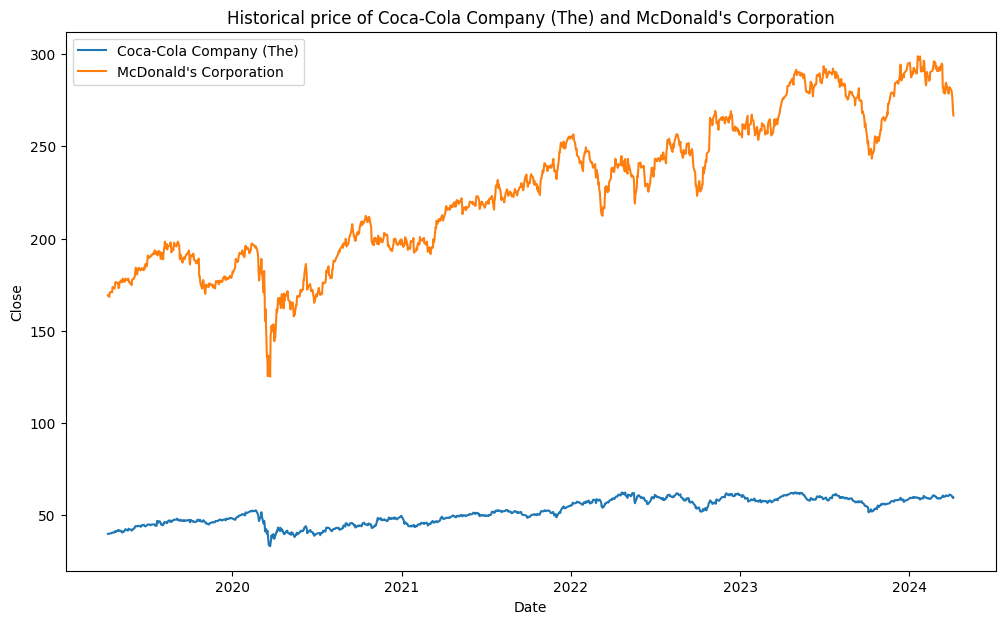


* ADF TEST FOR KO AND MCD

KO Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f720a60>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.611
P-value                         0.849
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

MCD Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f618790>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.678
P-value                         0.863
Lags                                7
-------------------------------------

Trend: N

,Coca-Cola Company (The) Stock Price,| Coca-Cola Company (The) Return,| McDonald's Corporation Stock Price,| McDonald's Corporation Return
ADF Test Statistic,0.61101,-36.733275,0.677869,-12.57048
5% Critical Value,-1.941216,-1.941216,-1.941217,-1.941217
Stationarity,NO,YES,NO,YES



If the Stock Price is non stationary and the return is Stationary,
then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.
If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.


* COINTEGRATION TEST

Phillips-Ouliaris Za Cointegration Test
Statistic: -21.29873944714272
P-value: 0.04306005601321773
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 0.4139
Trend: c
Distribution Order: 3

If the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.



In [ ]:
eg_test("KO","MCD")

Surprisingly the P-value of Coca Cola vs Mc Donnald Stocks are less than 0.05, so they are cointegrated.

## Pepsi vs Mc Donald

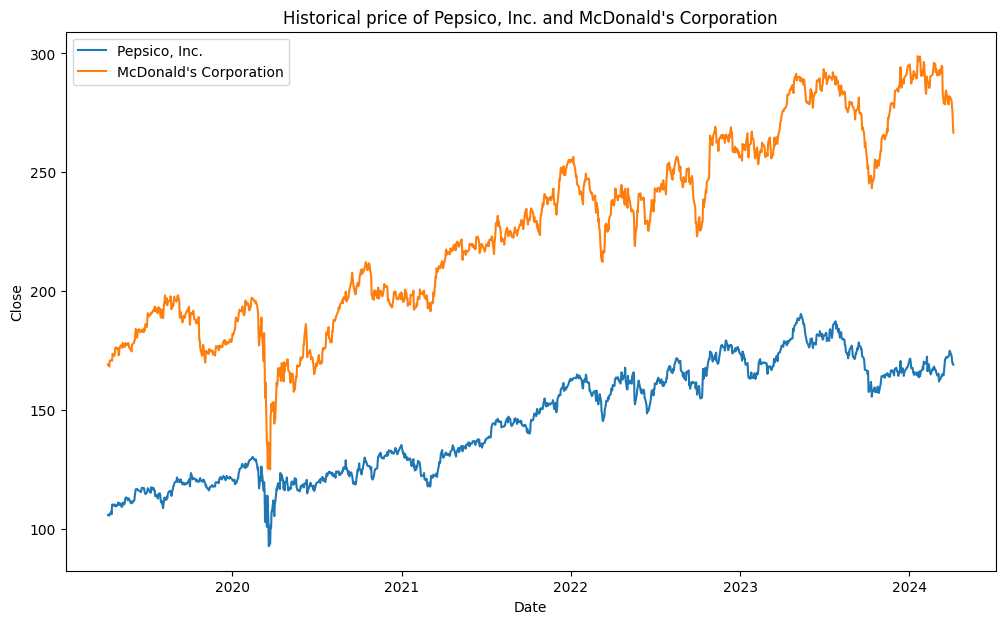


* ADF TEST FOR PEP AND MCD

PEP Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f722140>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.920
P-value                         0.904
Lags                                1
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

MCD Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7dcacdf0>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.678
P-value                         0.863
Lags                                7
-------------------------------------

Trend:

,"Pepsico, Inc. Stock Price","| Pepsico, Inc. Return",| McDonald's Corporation Stock Price,| McDonald's Corporation Return
ADF Test Statistic,0.919977,-42.454489,0.677869,-12.57048
5% Critical Value,-1.941216,-1.941216,-1.941217,-1.941217
Stationarity,NO,YES,NO,YES



If the Stock Price is non stationary and the return is Stationary,
then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.
If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.


* COINTEGRATION TEST

Phillips-Ouliaris Za Cointegration Test
Statistic: -24.862580996562585
P-value: 0.020079507399693775
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 6.5516
Trend: c
Distribution Order: 3

If the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.



In [ ]:
eg_test("PEP","MCD")

Surprisingly the P-value of Pepsi vs Mc Donnald Stocks are less than 0.05, so they are cointegrated.

#Dataset of American Express, VISA, and Master Card

## American Express vs VISA

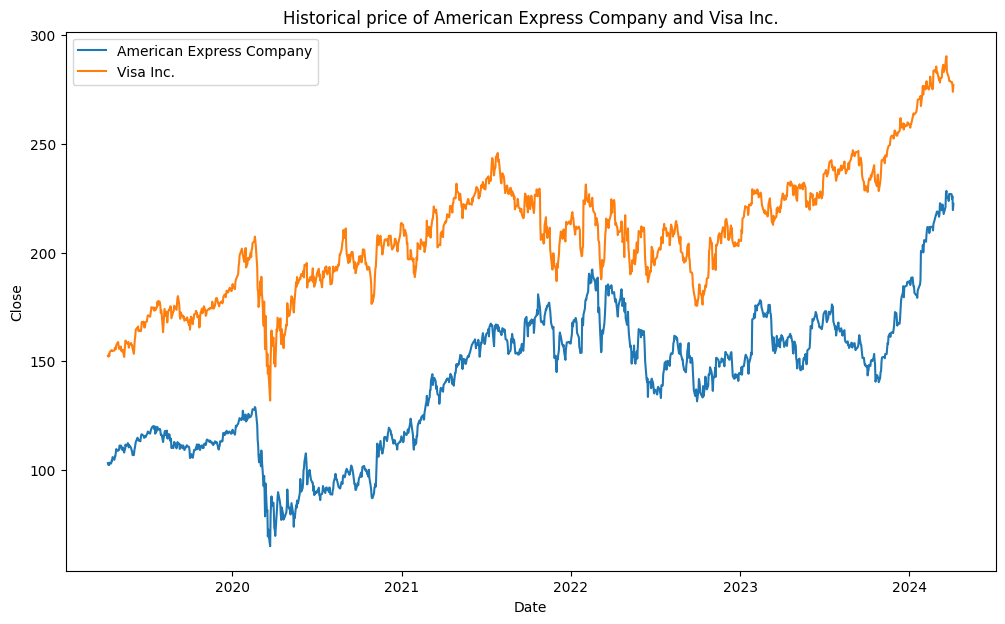


* ADF TEST FOR AXP AND V

AXP Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f63e1d0>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.959
P-value                         0.910
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

V Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f61b6a0>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.918
P-value                         0.904
Lags                                1
-------------------------------------

Trend: No 

,American Express Company Stock Price,| American Express Company Return,| Visa Inc. Stock Price,| Visa Inc. Return
ADF Test Statistic,0.958608,-36.216591,0.918487,-38.894009
5% Critical Value,-1.941216,-1.941216,-1.941216,-1.941216
Stationarity,NO,YES,NO,YES



If the Stock Price is non stationary and the return is Stationary,
then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.
If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.


* COINTEGRATION TEST

Phillips-Ouliaris Za Cointegration Test
Statistic: -9.058733844939734
P-value: 0.3748954107331665
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 10.703
Trend: c
Distribution Order: 3

If the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.



In [ ]:
eg_test("AXP","V")

The P-value of American Express vs VISA Stocks are much greater than 0.05, so they are not cointegrated.

## American Express vs Master Card

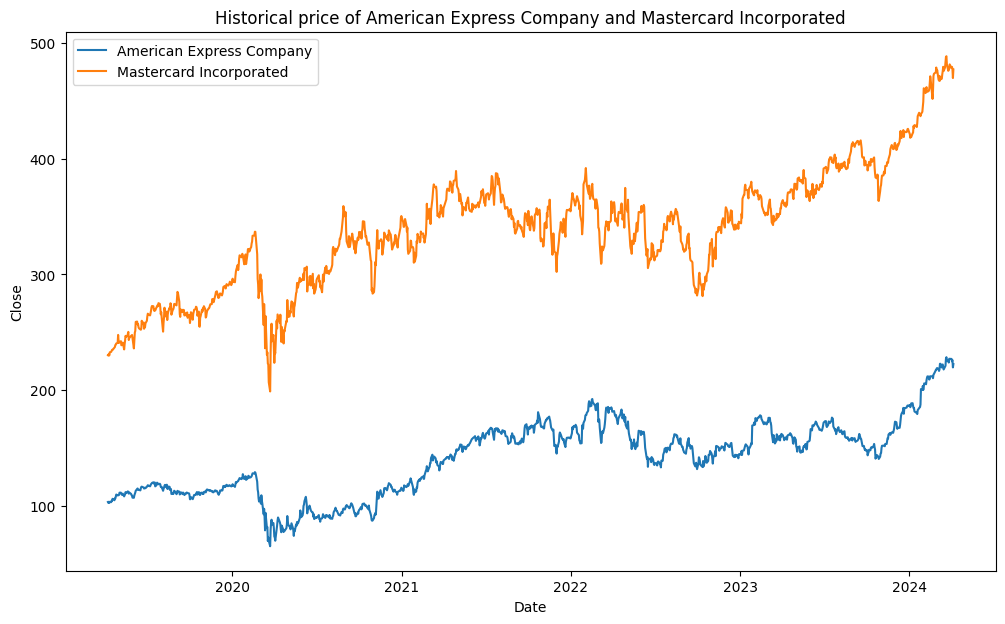


* ADF TEST FOR AXP AND MA

AXP Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda7f5831f0>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.959
P-value                         0.910
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

MA Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda8000e830>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.862
P-value                         0.895
Lags                                0
-------------------------------------

Trend: N

,American Express Company Stock Price,| American Express Company Return,| Mastercard Incorporated Stock Price,| Mastercard Incorporated Return
ADF Test Statistic,0.958608,-36.216591,0.862066,-37.088604
5% Critical Value,-1.941216,-1.941216,-1.941216,-1.941216
Stationarity,NO,YES,NO,YES



If the Stock Price is non stationary and the return is Stationary,
then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.
If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.


* COINTEGRATION TEST

Phillips-Ouliaris Za Cointegration Test
Statistic: -9.451723713002465
P-value: 0.3558235052374326
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 17.054
Trend: c
Distribution Order: 3

If the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.



In [ ]:
eg_test("AXP","MA")

The P-value of American Express vs Master Card Stocks are much greater than 0.05, so they are not cointegrated.

## VISA vs Master Card

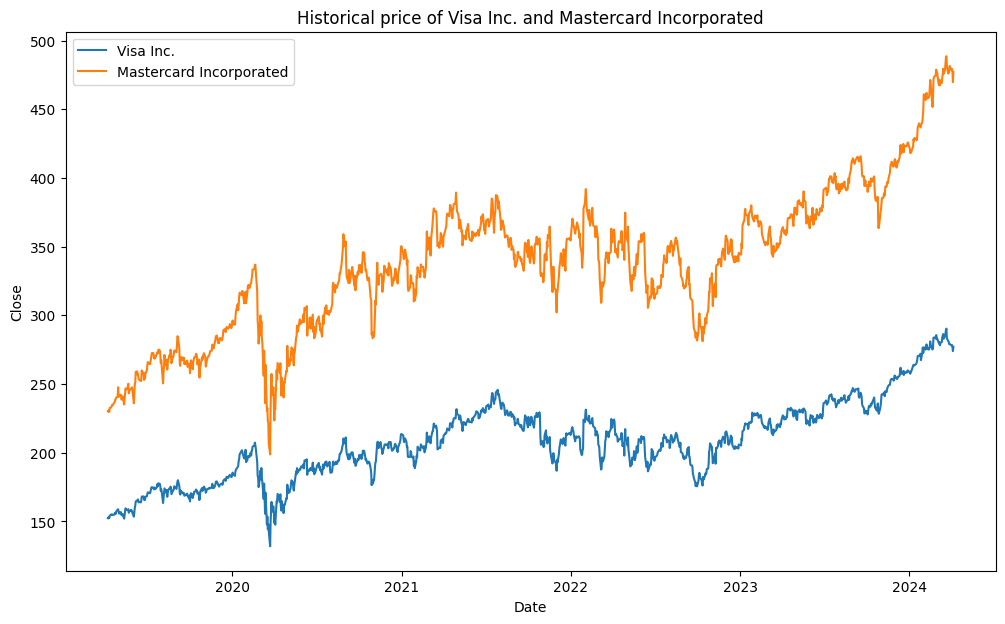


* ADF TEST FOR V AND MA

V Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda80049ab0>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.918
P-value                         0.904
Lags                                1
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

MA Augmented Dickey-Fuller Unit Root Test
 <bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7cda80603610>>

Test statistics and critical values: 
    Augmented Dickey-Fuller Results   
Test Statistic                  0.862
P-value                         0.895
Lags                                0
-------------------------------------

Trend: No Tr

,Visa Inc. Stock Price,| Visa Inc. Return,| Mastercard Incorporated Stock Price,| Mastercard Incorporated Return
ADF Test Statistic,0.918487,-38.894009,0.862066,-37.088604
5% Critical Value,-1.941216,-1.941216,-1.941216,-1.941216
Stationarity,NO,YES,NO,YES



If the Stock Price is non stationary and the return is Stationary,
then the time series is I(1), or a non-stationary time series that can be differenced once to become stationary.
If the time series is I(1), then we could move ahead to check the Phillips and Ouliaris cointegration test.


* COINTEGRATION TEST

Phillips-Ouliaris Za Cointegration Test
Statistic: -42.88910433246399
P-value: 0.0005557670600318641
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 14.562
Trend: c
Distribution Order: 3

If the time series is I(1) and the p-value of PO Test is less than 0.05 then this Stock Pairs are cointegrated.



In [ ]:
eg_test("V","MA")

Surprisingly the P-value of American Express vs VISA Stocks are much smaller than 0.05, so they seem to show the best cointegration.

#Error Correction Model (ECM) of VISA (against MasterCard)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)




                              UECM Model Results                              
Dep. Variable:                    D.V   No. Observations:                 1259
Model:                     UECM(1, 1)   Log Likelihood               -2238.753
Method:               Conditional MLE   S.D. of innovations            210.178
Date:                Mon, 08 Apr 2024   AIC                           4489.507
Time:                        16:16:31   BIC                           4520.330
Sample:                             1   HQIC                          4501.091
                                 1259                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1649      0.426      2.737      0.006       0.330       2.000
trend       9.843e-05      0.000      0.476      0.634      -0.000       0.001
V.L1          -0.0345      0.008     -4.585      0

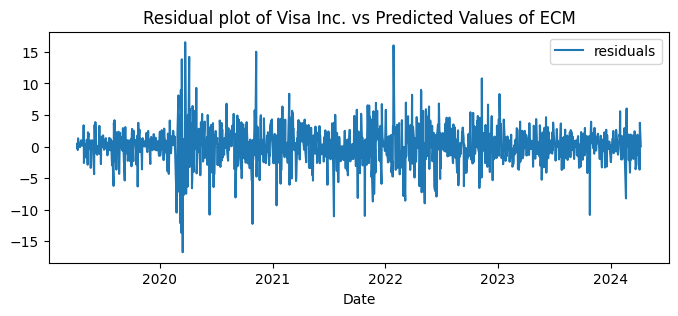

,Durbin-Watson Test for ECM residuals
Data Pairs,Visa Inc. and Mastercard Incorporated
Result,2.092985
Interpretation,No auto-correlation if around 2


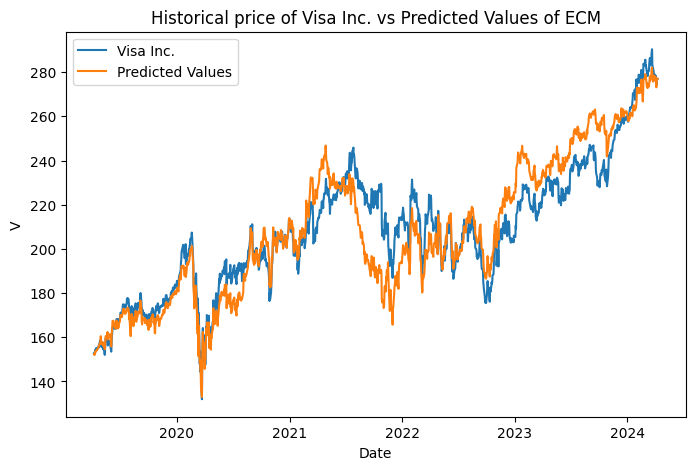

In [ ]:
  visa_pval=ec_model("V","MA")

#Error Correction Model (ECM) of MasterCard (against Visa)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)




                              UECM Model Results                              
Dep. Variable:                   D.MA   No. Observations:                 1259
Model:                     UECM(1, 1)   Log Likelihood               -2991.866
Method:               Conditional MLE   S.D. of innovations            342.338
Date:                Mon, 08 Apr 2024   AIC                           5995.732
Time:                        16:17:00   BIC                           6026.555
Sample:                             1   HQIC                          6007.316
                                 1259                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1089      0.776     -1.429      0.153      -2.632       0.414
trend          0.0004      0.000      0.934      0.351      -0.000       0.001
MA.L1         -0.0383      0.008     -4.886      0

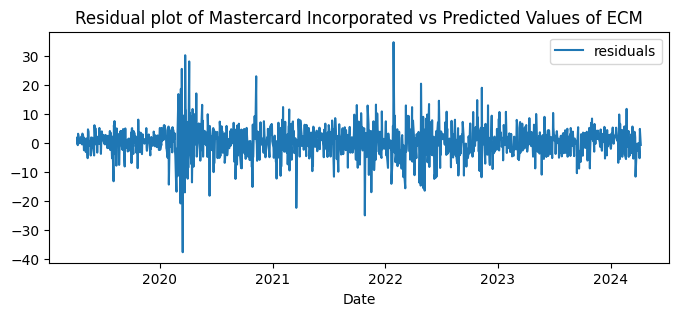

,Durbin-Watson Test for ECM residuals
Data Pairs,Mastercard Incorporated and Visa Inc.
Result,2.167399
Interpretation,No auto-correlation if around 2


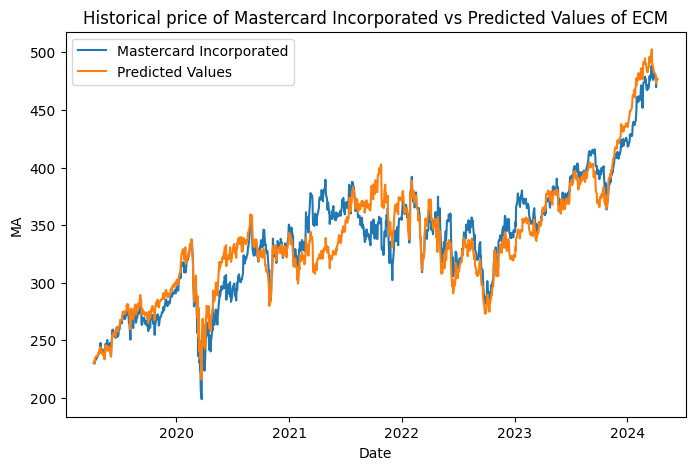

In [ ]:
mcard_pval=ec_model("MA","V")

#Analysis

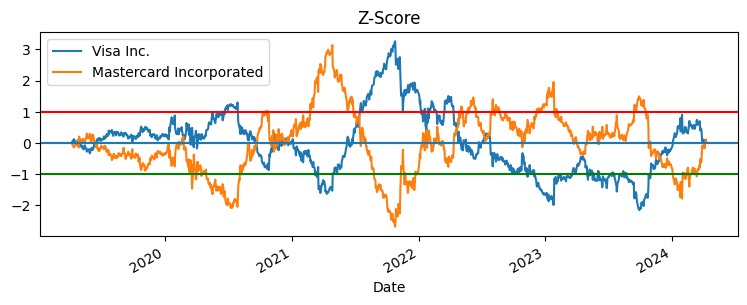

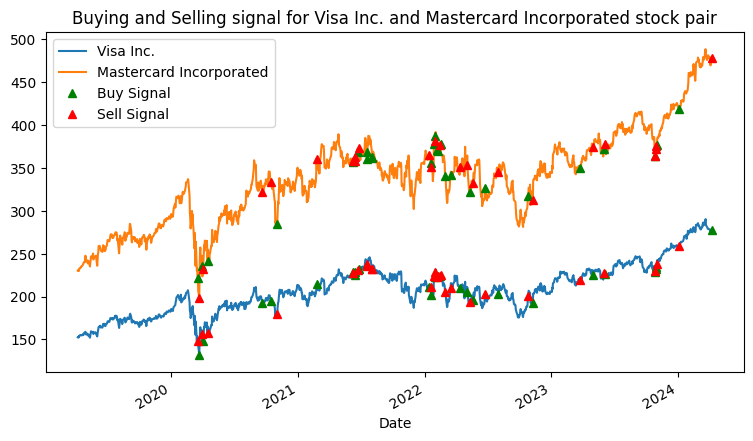

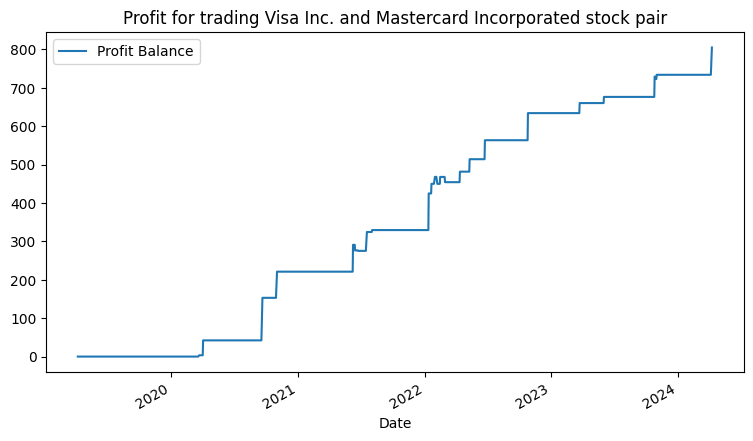

In [ ]:
 ticker1 ="V"
ticker2 = "MA"
time_period = '5y'
time_end = None

ticker1_data = yf.Ticker(ticker1)
ticker2_data = yf.Ticker(ticker2)

ticker1_hist = ticker1_data.history(period=time_period,end=time_end)
ticker2_hist = ticker2_data.history(period=time_period,end=time_end)

ticker1_price = ticker1_hist["Close"].rename(ticker1, inplace = True)
ticker2_price = ticker2_hist["Close"].rename(ticker2, inplace = True)

t1_name=ticker1_data.info["shortName"]
t2_name=ticker2_data.info["shortName"]

t1_z_score=zscore((ticker1_price-visa_pval))
t2_z_score=zscore((ticker2_price-mcard_pval))
t1_z_score.plot(figsize=(9,3),title="Z-Score")
t2_z_score.plot()
plt.axhline(t1_z_score.mean())
plt.axhline(t2_z_score.mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
#plt.xlim('2013-01-01', '2018-01-01')
plt.legend([t1_name,t2_name])
plt.show()


signal=pd.DataFrame(data={'t1_price':[],'t2_price':[],'t1_z_score':[],'t2_z_score':[],
                          't1_pos':[],'t2_pos':[],'t1_qty':[],'t2_qty':[],'t1_stk':[],
                          't2_stk':[],'status':[],'balance':[]})
signal['t1_price']=ticker1_price.to_list()
signal['t2_price']=ticker2_price.to_list()
signal['t1_z_score']=t1_z_score.to_list()
signal['t2_z_score']=t2_z_score.to_list()
#signal.reset_index()

#display(signal.tail())

pos_entry=1.0
pos_exit=0.0
trx_size=1000
lzs_t1buy=0
lzs_t2buy=0
lzs_t1sell=0
lzs_t2sell=0
status='close'
stock_t1=0
stock_t2=0
balance=0

for i, row in signal.iterrows():
  #print(index,row['t1_z_score'],row['t2_z_score'])
  #signal.at[i,'status'] = 'Done'
  #print(status,row['t1_z_score'])
  if status=='close' and row['t1_z_score'] > pos_entry:
    status='open'
    #print(i,'state 1',status)
    signal.at[i,'status']='open'
    signal.at[i,'t1_pos']='sell'
    signal.at[i,'t2_pos']='buy'
    signal.at[i,'t1_qty']=trx_size/row['t1_price']
    stock_t1 -= signal.at[i,'t1_qty']
    signal.at[i,'t2_qty']=trx_size/row['t2_price']
    stock_t2 += signal.at[i,'t2_qty']
    lzs_t1buy=0
    lzs_t1sell=row['t1_z_score']
  elif status=='close' and row['t2_z_score'] < -pos_entry:
    status='open'
    #print(i,'state 2',status)
    signal.at[i,'status']='open'
    signal.at[i,'t1_pos']='sell'
    signal.at[i,'t2_pos']='buy'
    signal.at[i,'t1_qty']=trx_size/row['t1_price']
    stock_t1 -= signal.at[i,'t1_qty']
    signal.at[i,'t2_qty']=trx_size/row['t2_price']
    stock_t2 += signal.at[i,'t2_qty']
    lzs_t2buy=row['t2_z_score']
    lzs_t2sell=0
  elif status=='close' and row['t2_z_score'] > pos_entry:
    status='open'
    #print(i,'state 3',status)
    signal.at[i,'status']='open'
    signal.at[i,'t1_pos']='buy'
    signal.at[i,'t2_pos']='sell'
    signal.at[i,'t1_qty']=trx_size/row['t1_price']
    stock_t1 += signal.at[i,'t1_qty']
    signal.at[i,'t2_qty']=trx_size/row['t2_price']
    stock_t2 -= signal.at[i,'t2_qty']
    lzs_t2buy=0
    lzs_t2sell=row['t2_z_score']
  elif status=='close' and row['t1_z_score'] < -pos_entry:
    status='open'
    #print(i,'state 4',status)
    signal.at[i,'status']='open'
    signal.at[i,'t1_pos']='buy'
    signal.at[i,'t2_pos']='sell'
    signal.at[i,'t1_qty']=trx_size/row['t1_price']
    stock_t1 += signal.at[i,'t1_qty']
    signal.at[i,'t2_qty']=trx_size/row['t2_price']
    stock_t2 -= signal.at[i,'t2_qty']
    lzs_t1buy=row['t1_z_score']
    lzs_t1sell=0

  #Close Position
  elif status=='open' and row['t1_z_score'] > pos_exit and signal.at[i-1,'t1_z_score'] < pos_exit:
    status='close'
    #print(i,'state 5',status)
    signal.at[i,'status']=status
    signal.at[i,'t1_pos']='sell'
    signal.at[i,'t2_pos']='buy'
    signal.at[i,'t1_qty']=stock_t1
    signal.at[i,'t2_qty']=-stock_t2
    balance += signal.at[i,'t1_qty']*row['t1_price']-signal.at[i,'t2_qty']*row['t2_price']
    stock_t1=0
    stock_t2=0
    lzs_t1buy=0
    lzs_t1sell=0
  elif status=='open' and row['t2_z_score'] < pos_exit and signal.at[i-1,'t2_z_score'] > pos_exit:
    status='close'
    #print(i,'state 6',status)
    signal.at[i,'status']=status
    signal.at[i,'t1_pos']='sell'
    signal.at[i,'t2_pos']='buy'
    signal.at[i,'t1_qty']=stock_t1
    signal.at[i,'t2_qty']=-stock_t2
    balance += signal.at[i,'t1_qty']*row['t1_price']-signal.at[i,'t2_qty']*row['t2_price']
    stock_t1=0
    stock_t2=0
    lzs_t2buy=0
    lzs_t2sell=0
  elif status=='open' and row['t2_z_score'] > pos_exit and signal.at[i-1,'t2_z_score'] < pos_exit:
    status='close'
    #print(i,'state 7',status)
    signal.at[i,'status']=status
    signal.at[i,'t1_pos']='buy'
    signal.at[i,'t2_pos']='sell'
    signal.at[i,'t1_qty']=-stock_t1
    signal.at[i,'t2_qty']=stock_t2
    balance += -signal.at[i,'t1_qty']*row['t1_price']+signal.at[i,'t2_qty']*row['t2_price']
    stock_t1=0
    stock_t2=0
    lzs_t2buy=0
    lzs_t2sell=0
  elif status=='open' and row['t1_z_score'] < pos_exit and signal.at[i-1,'t1_z_score'] > pos_exit:
    status='close'
    #print(i,'state 8',status)
    signal.at[i,'status']=status
    signal.at[i,'t1_pos']='buy'
    signal.at[i,'t2_pos']='sell'
    signal.at[i,'t1_qty']=-stock_t1
    signal.at[i,'t2_qty']=stock_t2
    balance += -signal.at[i,'t1_qty']*row['t1_price']+signal.at[i,'t2_qty']*row['t2_price']
    stock_t1=0
    stock_t2=0
    lzs_t1buy=0
    lzs_t1sell=0

  signal.at[i,'status']=status
  signal.at[i,'t1_stk']=stock_t1
  signal.at[i,'t2_stk']=stock_t2
  signal.at[i,'balance']=balance

plt.figure(figsize=(9,5))
signal_t1 = pd.DataFrame()
signal_t1['price']=ticker1_price.copy()
signal_t1['pos']=signal['t1_pos'].to_list()
signal_t1['buy']=(signal_t1['pos']=='buy') * signal_t1['price']
signal_t1['sell']=(signal_t1['pos']=='sell') * signal_t1['price']
signal_t2 = pd.DataFrame()
signal_t2['price']=ticker2_price.copy()
signal_t2['pos']=signal['t2_pos'].to_list()
signal_t2['buy']=(signal_t2['pos']=='buy') * signal_t2['price']
signal_t2['sell']=(signal_t2['pos']=='sell') * signal_t2['price']
#display(signal_t1)

#sell_t1 = ticker1_price.copy()
#buy_t2 = signal['t2_price'].copy()
#sell_t2 = signal['t2_price'].copy()
#buy_t1[buy_t1['pos']!='buy'] = 0
#sell_t1[signal['t1_pos']!='sell'] = 0
#sns.lineplot(ticker1_price, label=t1_name)
#sns.lineplot(predicted_val, label="Predicted Values").set(title=f'Buying and Selling signal for {t1_name} based on Z-Score')
signal_t1['price'].plot(title=f'Buying and Selling signal for {t1_name} and {t2_name} stock pair')
signal_t2['price'].plot()
signal_t1['buy'].plot(color='g', linestyle='None', marker='^')
signal_t1['sell'].plot(color='r', linestyle='None', marker='^')
signal_t2['buy'].plot(color='g', linestyle='None', marker='^')
signal_t2['sell'].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ticker1_price.min()-20, ticker2_price.max()+20))
plt.legend([t1_name, t2_name, 'Buy Signal', 'Sell Signal'])
plt.show()

plt.figure(figsize=(9,5))
profit = pd.DataFrame()
profit['t1'] = ticker1_price.copy()
profit['t2'] = ticker2_price.copy()
profit['bal'] = signal['balance'].to_list()
profit['bal'].plot(title=f'Profit for trading {t1_name} and {t2_name} stock pair')
plt.legend(['Profit Balance'])
plt.show()


